<a href="https://colab.research.google.com/github/giaschutzer/datasci266-f24-final-project/blob/main/3_readability_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspellchecker
!pip install py-readability-metrics
!pip install textstat
!pip install langdetect

ERROR: Operation cancelled by user


In [ ]:
# Data imports
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import math

import os
os.chdir('/content/drive/MyDrive/Code + Data')
import tobit
from tobit import TobitModel

# import textstat
from nltk import WhitespaceTokenizer
# from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from spellchecker import SpellChecker
from langdetect import detect, LangDetectException
from readability import Readability

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
yelp_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/yelp_data.parquet')

## Feature Engineering & Tokenization

In [ ]:
# Create feature that counts number of words in each review

def word_count(line):
  return len(line.split())

yelp_data['num_words'] = yelp_data['text'].apply(word_count)

In [ ]:
# Create feature that counts number of characters in each review

yelp_data['num_characters'] = yelp_data['text'].apply(len)

In [ ]:
# Create feature that counts number of sentences for each review
def count_sentences(text):
  sentences = sent_tokenize(text)
  return len(sentences)

yelp_data['num_sentences'] = yelp_data['text'].apply(count_sentences)

In [ ]:
punc = '!()[]{};:"\,<>.?@#$%^&*_~+'

def clean_and_tokenize(text):

  # Strip punctuation and replace certain characters with white space
  text = text.replace("/", " ")
  text = text.replace("-", " ")
  text = text.replace("...", " ")
  text = text.translate(str.maketrans(' ', ' ', punc))

  # Tokenize text
  words = WhitespaceTokenizer().tokenize(text)

  return words

In [ ]:
# Check function on random row of the data

text = yelp_data['text'].iloc[0]
print(text)
cleaned_text = clean_and_tokenize(text)
print(cleaned_text)

Loved this tour! I grabbed a groupon and the price was great. It was the perfect way to explore New Orleans for someone who'd never been there before and didn't know a lot about the history of the city. Our tour guide had tons of interesting tidbits about the city, and I really enjoyed the experience. Highly recommended tour. I actually thought we were just going to tour through the cemetery, but she took us around the French Quarter for the first hour, and the cemetery for the second half of the tour. You'll meet up in front of a grocery store (seems strange at first, but it's not terribly hard to find, and it'll give you a chance to get some water), and you'll stop at a visitor center part way through the tour for a bathroom break if needed. This tour was one of my favorite parts of my trip!
['Loved', 'this', 'tour', 'I', 'grabbed', 'a', 'groupon', 'and', 'the', 'price', 'was', 'great', 'It', 'was', 'the', 'perfect', 'way', 'to', 'explore', 'New', 'Orleans', 'for', 'someone', "who'd"

In [ ]:
# Define function to count spelling errors

spell = SpellChecker(case_sensitive=True)

def count_spelling_errors(text):
    misspelled = spell.unknown(text)
    num_misspelled = sum(1 for word in text if word in misspelled)
    # wrds = [word for word in text if word in misspelled]
    return num_misspelled #, misspelled, #wrds

In [ ]:
# Test spell check function on random row of data
print(count_spelling_errors(WhitespaceTokenizer().tokenize(text)))
print(count_spelling_errors(cleaned_text))

16
1


In [ ]:
# Apply spell check function to yelp data
yelp_data['num_spell_errors'] = yelp_data['text'].apply(clean_and_tokenize)
yelp_data['num_spell_errors'] = yelp_data['num_spell_errors'].apply(count_spelling_errors)

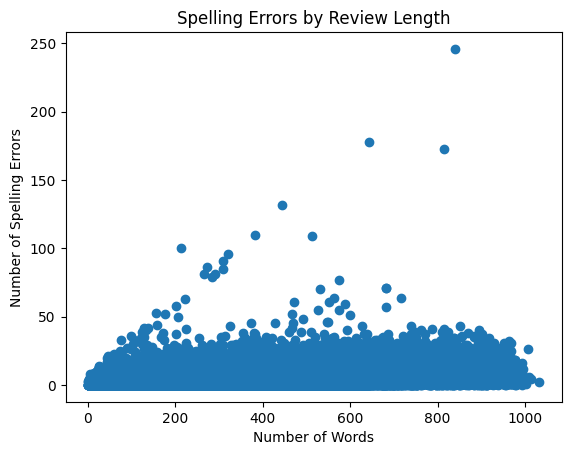

In [ ]:
# Plot spelling errors by length of review

plt.scatter(yelp_data['num_words'], yelp_data['num_spell_errors'])
plt.xlabel('Number of Words')
plt.ylabel('Number of Spelling Errors')
plt.title('Spelling Errors by Review Length')
plt.show()

In [ ]:
yelp_data['num_spell_errors'].describe()

,num_spell_errors
count,1.872289e+06
mean,1.257545e+00
std,2.517716e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.270000e+02


In [ ]:
outliers = yelp_data.loc[yelp_data['num_spell_errors'] > 10]['text']

In [ ]:
print(outliers)

419        The worst Italian food I have ever tasted!!! I...
684        Im australian so im use to fresh seafood and t...
688        I'd heard the hype. Seen the NY Times article....
748        5 stars on the beignets.  3 huge beignets for ...
963        Op suggestie van yelp- hier geweest op onze ee...
                                 ...                        
1871871    Dear (South)Korea, \n\nYou sure are looking sm...
1871981    I haven't had steak in a long time and I had s...
1872009    Masala Kitchen Kati Rolls and Platters really ...
1872269    This restaurant has it all going on.  Contempo...
1872272    Great atmosphere, great service and great food...
Name: text, Length: 12723, dtype: object


In [ ]:
def detect_language(text):
    """Detects the language of the given text.

    Args:
        text: The text to analyze.

    Returns:
        The detected language code (e.g., 'en', 'fr', 'es') or 'unknown' if detection fails.
    """
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

In [ ]:
yelp_data['language'] = yelp_data['text'].apply(detect_language)

In [ ]:
non_english_ids = yelp_data.loc[yelp_data['language'] != 'en', 'review_id']

In [ ]:
non_english_ids.to_csv('/content/drive/MyDrive/Code + Data/non_english_ids.csv', index=True)

In [ ]:
non_english_ids = pd.read_csv("/content/drive/MyDrive/Code + Data/non_english_ids.csv")

# Check rows before drop
print(f'There are {yelp_data.shape[0]} rows before dropping')

# Create a boolean mask
mask = ~yelp_data['review_id'].isin(non_english_ids['review_id'])

# Drop the rows
yelp_data = yelp_data[mask]

# Check rows after drop
print(f'There are {yelp_data.shape[0]} rows after dropping')

There are 1872289 rows before dropping
There are 1870042 rows after dropping


In [ ]:
# Calculate additional readibility metrics

yelp_data['automated_readibility_index'] = yelp_data['text'].apply(textstat.automated_readability_index)
yelp_data['gunning'] = yelp_data['text'].apply(textstat.gunning_fog)
yelp_data['coleman_liau'] = yelp_data['text'].apply(textstat.coleman_liau_index)
yelp_data['flesch_reading_ease'] = yelp_data['text'].apply(textstat.flesch_reading_ease)
yelp_data['flesch_kincaid_grade'] = yelp_data['text'].apply(textstat.flesch_kincaid_grade)
yelp_data['smog'] = yelp_data['text'].apply(textstat.smog_index)

In [ ]:
# Checkpoint dataset with updated readability metrics

yelp_data.to_parquet('/content/drive/MyDrive/Code + Data/yelp_data_readability.parquet')

In [ ]:
yelp_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/yelp_data_readability.parquet')

In [ ]:
yelp_data.shape

(1872289, 23)

### Final data cleaning

In [ ]:
# Downsample reviews
print(f"Original dataset size: {len(yelp_data)}")
print("0 helpful reviews", len(yelp_data[yelp_data['helpful'] == 0]))
minority_count = len(yelp_data[yelp_data['helpful'] > 0])
print(f"helpful > 0 reviews: {minority_count}")

majority_class = yelp_data[yelp_data['helpful'] == 0]
minority_class = yelp_data[yelp_data['helpful'] > 0]

minority_count = len(minority_class)
target_majority_size = int(minority_count)  # Keep 1x as many majority class reviews; ~280k

# Downsample the majority class
downsampled_majority = majority_class.sample(n=target_majority_size, random_state=42)
balanced_data = pd.concat([downsampled_majority, minority_class])

# Shuffle
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
yelp_data = balanced_data

print(f"Original dataset size: {len(yelp_data)}")
print("0 helpful reviews", len(yelp_data[yelp_data['helpful'] == 0]))
minority_count = len(yelp_data[yelp_data['helpful'] > 0])
print(f"helpful > 0 reviews: {minority_count}")

Original dataset size: 1872289
0 helpful reviews 1149206
helpful > 0 reviews: 723082
Original dataset size: 1446164
0 helpful reviews 723082
helpful > 0 reviews: 723082


In [ ]:
yelp_data['helpful'] = yelp_data['helpful'].apply(lambda x: x * 100)

In [ ]:
yelp_data['helpful'].describe()

,helpful
count,1.445304e+06
mean,1.903930e-01
std,4.748418e-01
min,0.000000e+00
25%,0.000000e+00
50%,7.516536e-03
75%,2.288330e-01
max,3.808463e+01


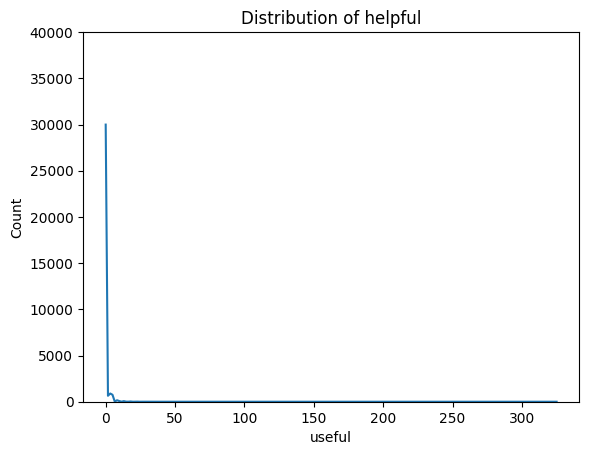

In [ ]:
sns.histplot(yelp_data['useful'], kde=True).set_title('Distribution of helpful')
plt.ylim(0,40000)
plt.show()

<Axes: xlabel='useful', ylabel='Density'>

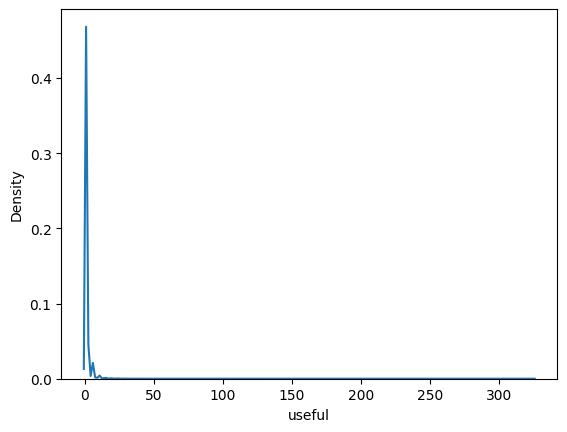

In [ ]:
sns.kdeplot(data=yelp_data, x='useful')

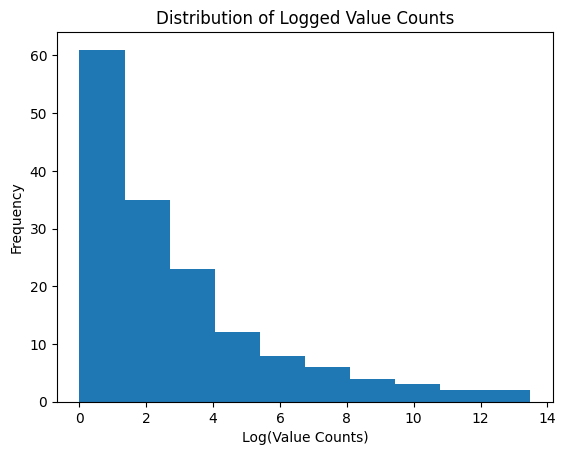

In [ ]:
# yelp_data['useful'].value_counts()

# Calculate value counts
value_counts = yelp_data['useful'].value_counts()

# Take the logarithm of the value counts
log_value_counts = np.log(value_counts)

# Plot the distribution
plt.hist(log_value_counts, bins=10)
plt.xlabel("Log(Value Counts)")
plt.ylabel("Frequency")
plt.title("Distribution of Logged Value Counts")
plt.show()

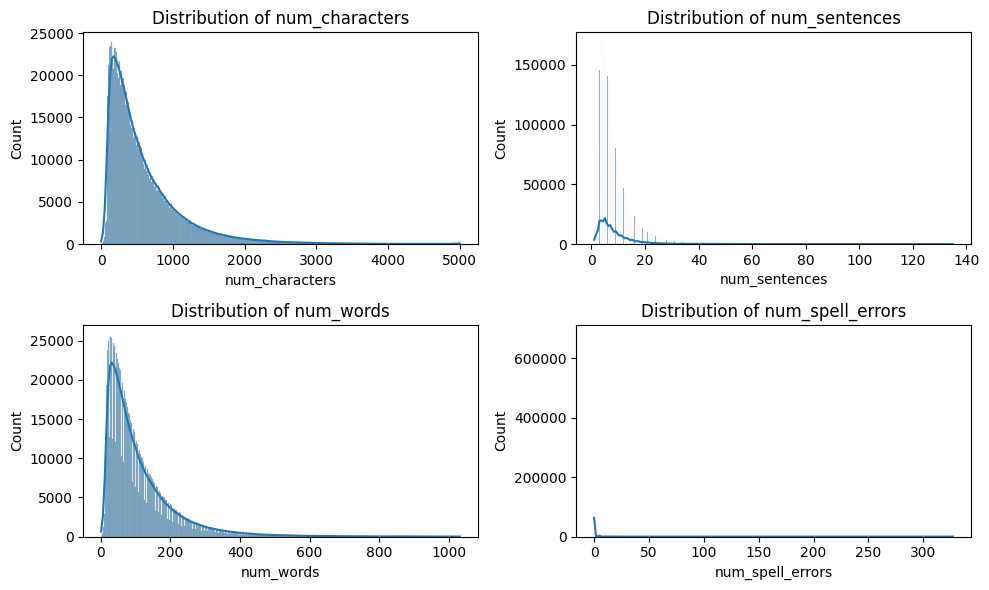

In [ ]:
# Print feature distributions

import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

sns.histplot(yelp_data['num_characters'], kde=True, ax=axs[0, 0]).set_title('Distribution of num_characters')
sns.histplot(yelp_data['num_sentences'], kde=True, ax=axs[0, 1]).set_title('Distribution of num_sentences')
sns.histplot(yelp_data['num_words'], kde=True, ax=axs[1, 0]).set_title('Distribution of num_words')
sns.histplot(yelp_data['num_spell_errors'], kde=True, ax=axs[1, 1]).set_title('Distribution of num_spell_errors')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

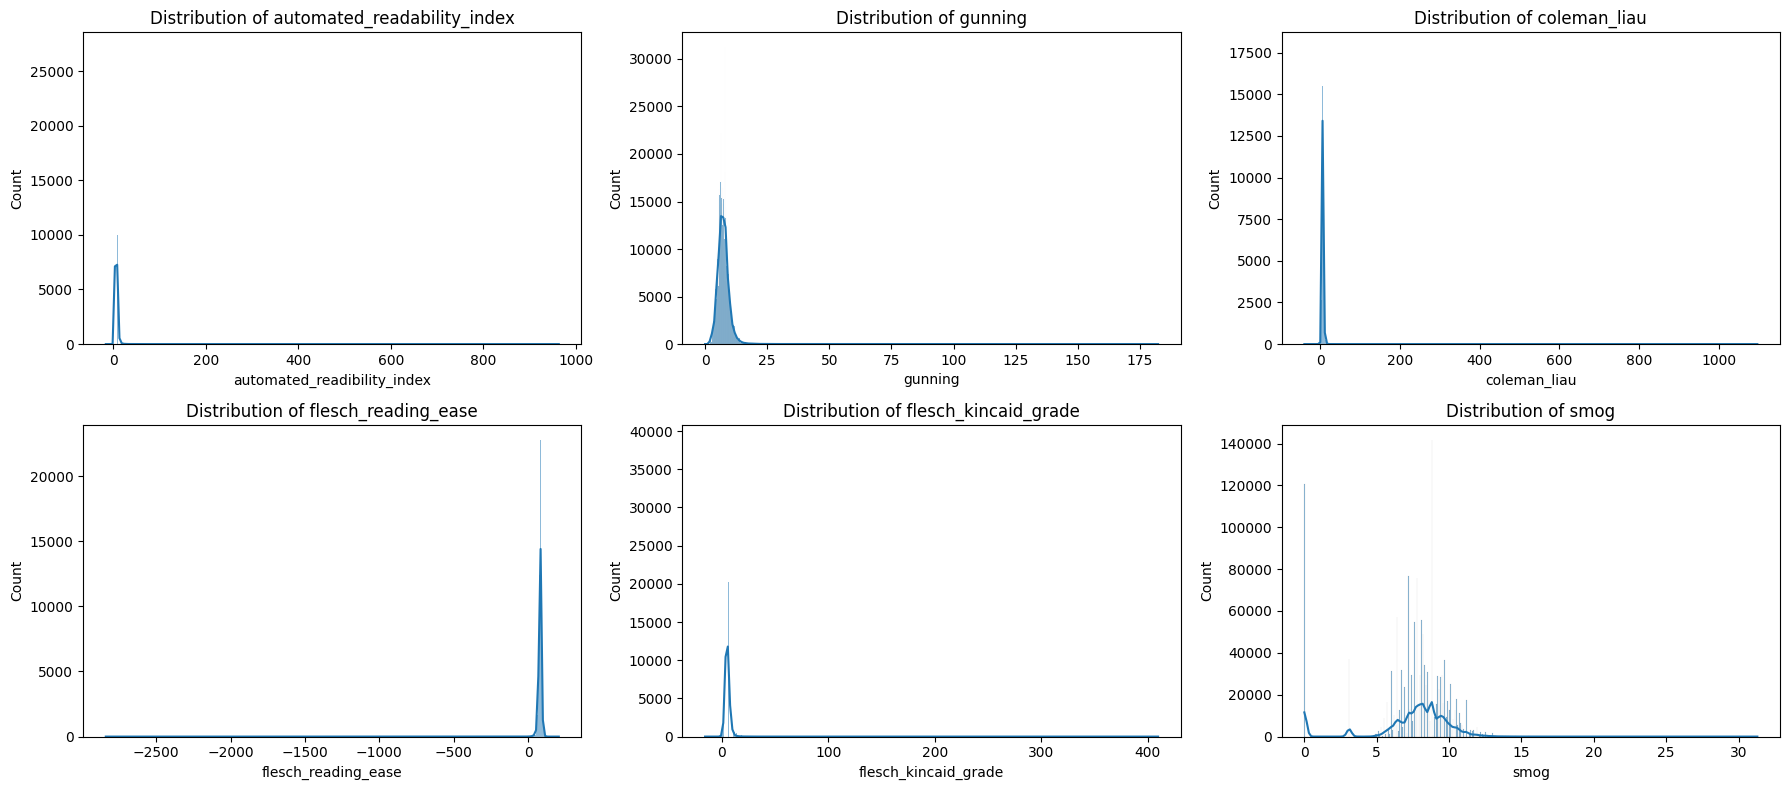

In [ ]:
# Print readability metric distributions

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Plot the distribution of each variable
sns.histplot(yelp_data['automated_readibility_index'], kde=True, ax=axs[0, 0]).set_title('Distribution of automated_readability_index')
sns.histplot(yelp_data['gunning'], kde=True, ax=axs[0, 1]).set_title('Distribution of gunning')
sns.histplot(yelp_data['coleman_liau'], kde=True, ax=axs[0, 2]).set_title('Distribution of coleman_liau')
sns.histplot(yelp_data['flesch_reading_ease'], kde=True, ax=axs[1, 0]).set_title('Distribution of flesch_reading_ease')
sns.histplot(yelp_data['flesch_kincaid_grade'], kde=True, ax=axs[1, 1]).set_title('Distribution of flesch_kincaid_grade')
sns.histplot(yelp_data['smog'], kde=True, ax=axs[1, 2]).set_title('Distribution of smog')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Check descriptive statistics
yelp_data[['automated_readibility_index','gunning','coleman_liau','flesch_reading_ease', 'flesch_kincaid_grade', 'smog']].describe()

,automated_readibility_index,gunning,coleman_liau,flesch_reading_ease,flesch_kincaid_grade,smog
count,1.446164e+06,1.446164e+06,1.446164e+06,1.446164e+06,1.446164e+06,1.446164e+06
mean,6.391389e+00,7.376043e+00,6.781166e+00,8.096641e+01,5.212564e+00,7.493450e+00
std,4.552376e+00,2.636812e+00,4.103002e+00,1.130717e+01,2.585337e+00,2.761380e+00
min,-1.630000e+01,0.000000e+00,-3.961000e+01,-2.839790e+03,-1.570000e+01,0.000000e+00
25%,4.600000e+00,5.850000e+00,5.460000e+00,7.530000e+01,3.800000e+00,6.900000e+00
50%,6.000000e+00,7.130000e+00,6.640000e+00,8.183000e+01,5.000000e+00,8.100000e+00
75%,7.700000e+00,8.510000e+00,7.890000e+00,8.731000e+01,6.300000e+00,9.100000e+00
max,9.635000e+02,1.823000e+02,1.097200e+03,2.068400e+02,4.096000e+02,3.130000e+01


In [ ]:
# Cap heavily skewed values

yelp_data['automated_readibility_index'] = yelp_data['automated_readibility_index'].clip(lower=0, upper=30)
yelp_data['gunning'] = yelp_data['gunning'].clip(lower=0, upper=20)
yelp_data['coleman_liau'] = yelp_data['coleman_liau'].clip(lower=0, upper=20)
yelp_data['flesch_reading_ease'] = yelp_data['flesch_reading_ease'].clip(lower=0, upper=100)
yelp_data['flesch_kincaid_grade'] = yelp_data['flesch_kincaid_grade'].clip(lower=0, upper=20)
yelp_data['smog'] = yelp_data['smog'].clip(lower=0, upper=20)

In [ ]:
# Check descriptive statistics after transformations

yelp_data[['automated_readibility_index','gunning','coleman_liau','flesch_reading_ease', 'flesch_kincaid_grade', 'smog']].describe()

,automated_readibility_index,gunning,coleman_liau,flesch_reading_ease,flesch_kincaid_grade,smog
count,1.446164e+06,1.446164e+06,1.446164e+06,1.446164e+06,1.446164e+06,1.446164e+06
mean,6.348085e+00,7.345311e+00,6.755381e+00,8.090905e+01,5.189964e+00,7.493419e+00
std,2.832362e+00,2.307941e+00,2.079879e+00,1.032804e+01,2.248830e+00,2.761209e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.600000e+00,5.850000e+00,5.460000e+00,7.530000e+01,3.800000e+00,6.900000e+00
50%,6.000000e+00,7.130000e+00,6.640000e+00,8.183000e+01,5.000000e+00,8.100000e+00
75%,7.700000e+00,8.510000e+00,7.890000e+00,8.731000e+01,6.300000e+00,9.100000e+00
max,3.000000e+01,2.000000e+01,2.000000e+01,1.000000e+02,2.000000e+01,2.000000e+01


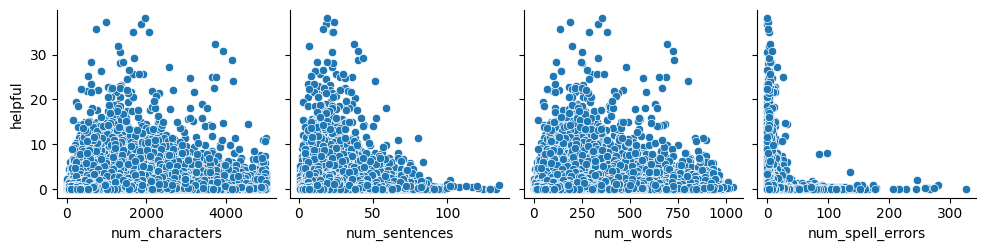

In [ ]:
sns.pairplot(
    yelp_data,
    x_vars=['num_characters', 'num_sentences', 'num_words', 'num_spell_errors'],
    y_vars='helpful'
)

plt.show()

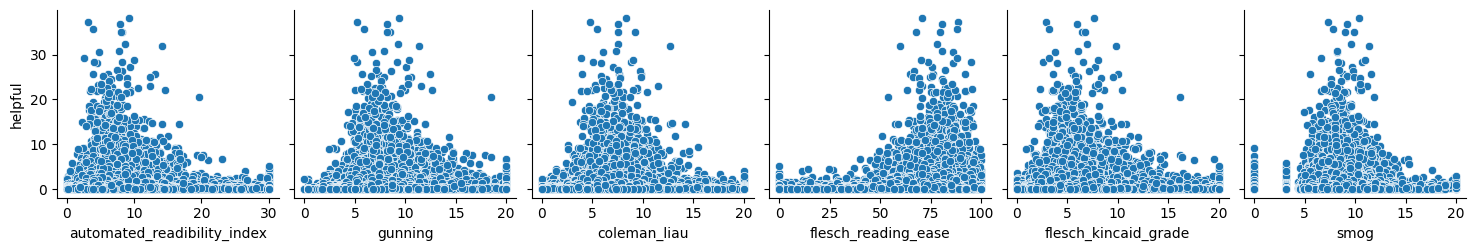

In [ ]:
sns.pairplot(
    yelp_data,
    x_vars=['automated_readibility_index','gunning','coleman_liau',
            'flesch_reading_ease', 'flesch_kincaid_grade', 'smog'],
    y_vars='helpful'
)

plt.show()

## Modeling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
def log_transform(data):
    """
    Transform Y variables into natural log, first incrementing all data by 1 to avoid log(0)
    """

    data_log = data.copy()

    if type(data_log) == pd.DataFrame:

      # Increment numerical columns by 1
      numerical_cols = data_log.select_dtypes(include=[np.number]).columns
      data_log[numerical_cols] += 1

      # Apply the log transformation
      data_log[numerical_cols] = data_log[numerical_cols].apply(np.log)

    else:
      # Increment columns by 1
      data_log += 1

      # Apply log transformation
      data_log = np.log(data_log)

    return data_log

In [ ]:
# Function to inverse transform Y_pred data

def inverse_transform(series):
  data_log = np.exp(series)

  return data_log - 1

### Model 1: Tobit with Standard Scaler

In [ ]:
# Define X and Y variables
X = yelp_data[['num_characters', 'num_sentences', 'num_words', 'num_spell_errors',
                'automated_readibility_index', 'gunning', 'coleman_liau',
                'flesch_reading_ease', 'flesch_kincaid_grade', 'smog']]
Y = yelp_data['helpful']

In [ ]:
# Spilt into training, validation, and testing

X.loc[:,'cens'] = yelp_data['helpful'].apply(lambda x: -1 if x==0 else 0) # Left-bounded for Tobit Regression

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

<ipython-input-303-5e8f30e2e6ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'cens'] = yelp_data['helpful'].apply(lambda x: -1 if x==0 else 0) # Left-bounded for Tobit Regression


In [ ]:
# Center variables

for var in X.columns[:-1]:
  X_train[var] = X_train[var] - X_train[var].mean()

for var in X.columns[:-1]:
  X_val[var] = X_val[var] - X_val[var].mean()

for var in X.columns[:-1]:
  X_test[var] = X_test[var] - X_test[var].mean()

In [ ]:
# Scale variables

cols = X.columns[:-1]
sc = StandardScaler()

X_train_sc = pd.DataFrame(sc.fit_transform(X_train[cols]), columns=cols, index=X_train.index).join(X_train['cens'])
X_val_sc = pd.DataFrame(sc.fit_transform(X_val[cols]), columns=cols, index=X_val.index).join(X_val['cens'])
X_test_sc = pd.DataFrame(sc.transform(X_test[cols]), columns=cols, index=X_test.index).join(X_test['cens'])

In [ ]:
# Train tobit model
model_1 = TobitModel()
results_1 = model_1.fit(
    X_train_sc.loc[:, X_train_sc.columns != 'cens'],
    Y_train,
    cens=X_train_sc['cens'],
    verbose=True,
    tol=1e-6
)

# Predict using validation data
y_pred_1 = model_1.predict(X_val_sc.loc[:, X_val_sc.columns != 'cens'])

# Report errors
readability_mse_1 = mean_squared_error(Y_val, y_pred_1)
readability_rmse_1 = math.sqrt(readability_mse_1)
readability_mae_1 =  mean_absolute_error(Y_val, y_pred_1)

print(f'MSE: {readability_mse_1}')
print(f'RMSE: {readability_rmse_1}')
print(f'MAE: {readability_mae_1}')

# Print estimated coefficients
for coef in X.columns[:-1]:
  print(f'Coefficient (for {coef}): {model_1.coef_[X.columns.get_loc(coef)]}')
print("Intercept:", model_1.intercept_)
print("Sigma (standard deviation):", model_1.sigma_)

         Current function value: 720226.254115
         Iterations: 36
         Function evaluations: 54
         Gradient evaluations: 54
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 720226.2541147992
        x: [-1.467e-01  4.997e-01  1.233e-01 -4.122e-01  4.287e-03
            -9.142e-02 -7.811e-02  5.436e-02  2.064e-01  3.334e-01
             6.170e-02  7.213e-01]
      nit: 36
      jac: [-3.274e-04  4.881e-04  1.376e-04  4.945e-04  8.338e-06
             1.771e-04  9.808e-04  2.656e-04 -7.459e-04  6.513e-04
             6.109e-04  4.585e-04]
 hess_inv: [[ 1.156e-06  4.093e-07 ... -1.152e-07 -4.292e-07]
            [ 4.093e-07  4.267e-04 ... -3.292e-06  8.169e-08]
            ...
            [-1.152e-07 -3.292e-06 ...  1.322e-06  5.194e-08]
            [-4.292e-07  8.169e-08 ...  5.194e-08  7.498e-07]]
     nfev: 54
     njev: 54
MSE: 0.3250914263398241
RMSE: 0.5701678931155489
MAE: 0.4096512980244245
Coefficient

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_1])
model_1_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_1_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_1_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_1_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_1_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_1_ndcg_all = ndcg_score(true_helpful, pred_helpful)


# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_1_ndcg_5}')
print(f'NDCG Score for k=25: {model_1_ndcg_25}')
print(f'NDCG Score for k=50: {model_1_ndcg_50}')
print(f'NDCG Score for k=100: {model_1_ndcg_100}')
print(f'NDCG Score for k=1000: {model_1_ndcg_1000}')
print(f'NDCG Score for all: {model_1_ndcg_all}')

NDCG Score for k=5: 0.010210578871636544
NDCG Score for k=25: 0.031327343513984064
NDCG Score for k=50: 0.04029466971667075
NDCG Score for k=100: 0.054872739873553254
NDCG Score for k=1000: 0.11427194695428292
NDCG Score for all: 0.8275940100541379


### Model 2: Tobit w/ Log of Helpful

In [ ]:
# Define X and Y variables
X = yelp_data[['num_characters', 'num_sentences', 'num_words', 'num_spell_errors',
                'automated_readibility_index', 'gunning', 'coleman_liau',
                'flesch_reading_ease', 'flesch_kincaid_grade', 'smog']]
Y = yelp_data['helpful']

In [ ]:
# Spilt into training, validation, and testing

X.loc[:,'cens'] = yelp_data['helpful'].apply(lambda x: -1 if x==0 else 0) # Left-bounded for Tobit Regression

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

<ipython-input-29-5e8f30e2e6ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'cens'] = yelp_data['helpful'].apply(lambda x: -1 if x==0 else 0) # Left-bounded for Tobit Regression


In [ ]:
# Center variables

for var in X.columns[:-1]:
  X_train[var] = X_train[var] - X_train[var].mean()

for var in X.columns[:-1]:
  X_val[var] = X_val[var] - X_val[var].mean()

for var in X.columns[:-1]:
  X_test[var] = X_test[var] - X_test[var].mean()

In [ ]:
# Scale variables

cols = X.columns[:-1]
sc = StandardScaler()

X_train_sc = pd.DataFrame(sc.fit_transform(X_train[cols]), columns=cols, index=X_train.index).join(X_train['cens'])
X_val_sc = pd.DataFrame(sc.fit_transform(X_val[cols]), columns=cols, index=X_val.index).join(X_val['cens'])
X_test_sc = pd.DataFrame(sc.transform(X_test[cols]), columns=cols, index=X_test.index).join(X_test['cens'])

In [ ]:
# Log scale Y variable

Y_train_log = log_transform(Y_train)
Y_val_log = log_transform(Y_val)
Y_test_log = log_transform(Y_test)

In [ ]:
# Train tobit model
model_2 = TobitModel()
results_2 = model_2.fit(
    X_train.loc[:, X_train.columns != 'cens'],
    Y_train_log,
    cens=X_train['cens'],
    verbose=True,
    tol=1e-6
)

y_pred_2 = model_2.predict(X_val.loc[:, X_val.columns != 'cens'])

# Report errors
readability_mse_2 = mean_squared_error(Y_val, inverse_transform(y_pred_2))
readability_rmse_2 = math.sqrt(readability_mse_2)
readability_mae_2 =  mean_absolute_error(Y_val, inverse_transform(y_pred_2))

print(f'MSE: {readability_mse_2}')
print(f'RMSE: {readability_rmse_2}')
print(f'MAE: {readability_mae_2}')

# Print estimated coefficients
for coef in X.columns[:-1]:
  print(f'Coefficient (for {coef}): {model_2.coef_[X.columns.get_loc(coef)]}')
print("Intercept:", model_2.intercept_)
print("Sigma (standard deviation):", model_2.sigma_)

         Current function value: 437412.179269
         Iterations: 33
         Function evaluations: 76
         Gradient evaluations: 64
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 437412.17926928937
        x: [-1.422e-02  4.182e-04  1.019e-02 -1.829e-03  1.278e-03
            -1.575e-02 -1.592e-02  1.448e-02  1.049e-02  7.092e-02
             1.265e-02  3.540e-01]
      nit: 33
      jac: [-2.563e-04  1.215e+00  1.283e-02  2.222e-01  2.517e-03
             3.827e-03  3.511e-03  2.058e-03 -1.241e-02  3.446e-03
             2.627e-03 -2.741e-03]
 hess_inv: [[ 2.083e-07  4.476e-10 ... -1.834e-09 -8.222e-08]
            [ 4.476e-10  1.007e-10 ... -2.775e-10  1.515e-10]
            ...
            [-1.834e-09 -2.775e-10 ...  2.946e-08  2.427e-10]
            [-8.222e-08  1.515e-10 ...  2.427e-10  1.523e-07]]
     nfev: 76
     njev: 64
MSE: 0.24267931413395913
RMSE: 0.49262492236381944
MAE: 0.2274255184239512
Coeffici

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
true_helpful = np.asarray([Y_val_log])
pred_helpful = np.asarray([y_pred_2])
model_2_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_2_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_2_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_2_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_2_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_2_ndcg_all = ndcg_score(true_helpful, pred_helpful)


# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_2_ndcg_5}')
print(f'NDCG Score for k=25: {model_2_ndcg_25}')
print(f'NDCG Score for k=50: {model_2_ndcg_50}')
print(f'NDCG Score for k=100: {model_2_ndcg_100}')
print(f'NDCG Score for k=1000: {model_2_ndcg_1000}')
print(f'NDCG Score for all: {model_2_ndcg_all}')

NDCG Score for k=5: 0.0797036474226639
NDCG Score for k=25: 0.12330557928896224
NDCG Score for k=50: 0.13893326749842436
NDCG Score for k=100: 0.16321788506856713
NDCG Score for k=1000: 0.2302787468189841
NDCG Score for all: 0.8904306093763342


### Model 3: OLS Regression MinMax Standardization

In [ ]:
# Define X and Y variables
X = yelp_data[['num_characters', 'num_sentences', 'num_words', 'num_spell_errors',
                'automated_readibility_index', 'gunning', 'coleman_liau',
                'flesch_reading_ease', 'flesch_kincaid_grade', 'smog']]
Y = yelp_data['helpful']

In [ ]:
# Spilt into training, validation, and testing

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [ ]:
# Scale X variables

cols = X_train.columns
sc = MinMaxScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=cols)
X_val_sc = pd.DataFrame(sc.fit_transform(X_val), columns=cols)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=cols)

In [ ]:
# Build and train regression model using standardized features

# Define and fit model
readability_model_3 = LinearRegression()
readability_model_3.fit(X_train_sc, Y_train)

y_pred_3 = readability_model_3.predict(X_test_sc)

# Calculate mean squared error
readability_mse_3 = mean_squared_error(Y_test, y_pred_3)
readability_rmse_3 = math.sqrt(readability_mse_3)
readability_mae_3 = mean_absolute_error(Y_test, y_pred_3)

print(f'MSE: {readability_mse_3}')
print(f'RMSE: {readability_rmse_3}')
print(f'MAE: {readability_mae_3}')
for coef in X.columns:
  print(f'Coefficient (for {coef}): {readability_model_3.coef_[X.columns.get_loc(coef)]}')
print(f'Intercept: {readability_model_3.intercept_}')

MSE: 0.2120147799829181
RMSE: 0.46045062708494394
MAE: 0.20595328641302052
Coefficient (for num_characters): 3.0324942582516665
Coefficient (for num_sentences): 0.8829249154016492
Coefficient (for num_words): -2.6218816905396967
Coefficient (for num_spell_errors): -0.3814552842745637
Coefficient (for automated_readibility_index): -1.2032629070786507
Coefficient (for gunning): -1.1389486277789913
Coefficient (for coleman_liau): 1.0339977904815287
Coefficient (for flesch_reading_ease): 9.554301261488833
Coefficient (for flesch_kincaid_grade): 8.802897176150587
Coefficient (for smog): 0.07159694038708758
Intercept: -9.520829347902405


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


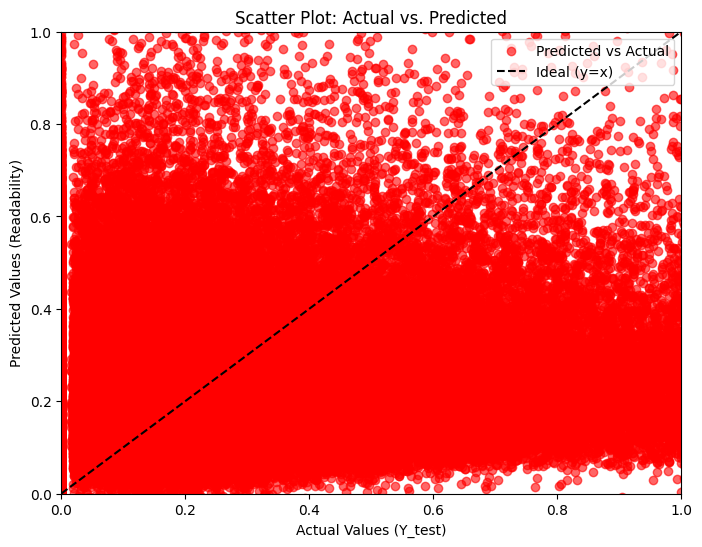

In [ ]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))

# Scatter the actual vs predicted values
plt.scatter(Y_test, y_pred_3, color='red', alpha=0.6, label='Predicted vs Actual')

# Ideal line y=x (best case scenario where predictions match actual values)
plt.plot([0, 1], [0, 1], 'k--', label='Ideal (y=x)')

# Set both x and y axis from 0 to 1 (since Y_test and Y_pred range between 0 and 1)
plt.xlim(0, 1)
plt.ylim(0, .1)

# Labels and title
plt.xlabel('Actual Values (Y_test)')
plt.ylabel('Predicted Values (Readability)')
plt.title('Scatter Plot: Actual vs. Predicted')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
# NDCG
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_3])

modelA_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
modelA_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
modelA_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
modelA_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
modelA_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
modelA_ndcg_all = ndcg_score(true_helpful, pred_helpful)

# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {modelA_ndcg_5}')
print(f'NDCG Score for k=25: {modelA_ndcg_25}')
print(f'NDCG Score for k=50: {modelA_ndcg_50}')
print(f'NDCG Score for k=100: {modelA_ndcg_100}')
print(f'NDCG Score for k=1000: {modelA_ndcg_1000}')
print(f'NDCG Score for all: {modelA_ndcg_all}')

NDCG Score for k=5: 0.03227113047139347
NDCG Score for k=25: 0.026638510382856823
NDCG Score for k=50: 0.029250029704235923
NDCG Score for k=100: 0.04420605892712942
NDCG Score for k=1000: 0.08105491848523229
NDCG Score for all: 0.7954982550178115


### Model 4: OLS Regression with Log Transformation

In [ ]:
# Define X and Y variables

X = yelp_data[['num_characters', 'num_sentences', 'num_words', 'num_spell_errors',
                'automated_readibility_index', 'gunning', 'coleman_liau',
                'flesch_reading_ease', 'flesch_kincaid_grade', 'smog']]
Y = yelp_data['helpful']

In [ ]:
# Spilt into training, validation, and testing

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

In [ ]:
# Apply log transformation

Y_train_log = log_transform(Y_train)
Y_val_log = log_transform(Y_val)
Y_test_log = log_transform(Y_test)

In [ ]:
# Build and train regression model using log features

# Define and fit model
readability_model_4 = LinearRegression()
readability_model_4.fit(X_train, Y_train_log)

y_pred_4 = readability_model_4.predict(X_val)

# Calculate mean squared error
readability_mse_4 = mean_squared_error(Y_val, inverse_transform(y_pred_4))
readability_rmse_4 = math.sqrt(readability_mse_4)
readability_mae_4 =  mean_absolute_error(Y_test, inverse_transform(y_pred_4))

print(f'MSE: {readability_mse_4}')
print(f'RMSE: {readability_rmse_4}')
print(f'MAE: {readability_mae_4}')

for coef in X.columns:
  print(f'Coefficient (for {coef}): {readability_model_4.coef_[X.columns.get_loc(coef)]}')
print(f'Intercept: {readability_model_4.intercept_}')

MSE: 0.2104534574613947
RMSE: 0.45875206534836954
MAE: 0.21791741055906544
Coefficient (for num_characters): 0.0003236007442650488
Coefficient (for num_sentences): 0.0049453077763616056
Coefficient (for num_words): -0.0013833969871834685
Coefficient (for num_spell_errors): -0.0005652008385036146
Coefficient (for automated_readibility_index): 0.0005867865183230736
Coefficient (for gunning): -0.0039448706301891
Coefficient (for coleman_liau): -0.0018508833748125868
Coefficient (for flesch_reading_ease): 0.002405258783737487
Coefficient (for flesch_kincaid_grade): 0.016479998323786552
Coefficient (for smog): 0.002604717117711452
Intercept: -0.20454617461775362


In [ ]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))

# Scatter the actual vs predicted values
plt.scatter(Y_test, inverse_transform(y_pred2), color='red', alpha=0.6, label='Predicted vs Actual')

# Ideal line y=x (best case scenario where predictions match actual values)
plt.plot([0, 1], [0, 1], 'k--', label='Ideal (y=x)')

# Set both x and y axis from 0 to 1 (since Y_test and Y_pred range between 0 and 1)
plt.xlim(0, 1)
plt.ylim(0, .1)

# Labels and title
plt.xlabel('Actual Values (Y_test)')
plt.ylabel('Predicted Values (Readability)')
plt.title('Scatter Plot: Actual vs. Predicted')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.legend()
plt.show()

NameError: name 'y_pred2' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# NDCG
true_helpful = np.asarray([Y_val_log])
pred_helpful = np.asarray([y_predB])

modelB_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
modelB_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
modelB_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
modelB_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
modelB_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
modelB_ndcg_all = ndcg_score(true_helpful, pred_helpful)

# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {modelB_ndcg_5}')
print(f'NDCG Score for k=25: {modelB_ndcg_25}')
print(f'NDCG Score for k=50: {modelB_ndcg_50}')
print(f'NDCG Score for k=100: {modelB_ndcg_100}')
print(f'NDCG Score for k=1000: {modelB_ndcg_1000}')
print(f'NDCG Score for all: {modelB_ndcg_all}')

### Model 5: Tobit Regression with Quadratic Terms

In [ ]:
# Define X and Y variables
X = yelp_data[['num_characters', 'num_sentences', 'num_words', 'num_spell_errors',
                'automated_readibility_index', 'gunning', 'coleman_liau',
                'flesch_reading_ease', 'flesch_kincaid_grade', 'smog']]
Y = yelp_data['helpful']

In [ ]:
# Spilt into training, validation, and testing

X.loc[:,'cens'] = yelp_data['helpful'].apply(lambda x: -1 if x==0 else 0) # Left-bounded for Tobit Regression

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

<ipython-input-274-5e8f30e2e6ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'cens'] = yelp_data['helpful'].apply(lambda x: -1 if x==0 else 0) # Left-bounded for Tobit Regression


In [ ]:
# Center variables

for var in X.columns[:-1]:
  X_train[var] = X_train[var] - X_train[var].mean()

for var in X.columns[:-1]:
  X_val[var] = X_val[var] - X_val[var].mean()

for var in X.columns[:-1]:
  X_test[var] = X_test[var] - X_test[var].mean()

In [ ]:
# Transform relevant features into polynomials / exponentiate

poly_features = ['automated_readibility_index', 'gunning', 'coleman_liau',
                 'flesch_kincaid_grade', 'smog']

X_train[poly_features] = X_train[poly_features].apply(lambda x: -x ** 2)
X_train['flesch_reading_ease'] = np.exp(X_train['flesch_reading_ease'])
X_train['num_spell_errors'] = np.exp(-X_train['num_spell_errors'])

X_val[poly_features] = X_val[poly_features].apply(lambda x: -x ** 2)
X_val['flesch_reading_ease'] = np.exp(X_val['flesch_reading_ease'])
X_val['num_spell_errors'] = np.exp(-X_val['num_spell_errors'])

X_test[poly_features] = X_test[poly_features].apply(lambda x: -x ** 2)
X_test['flesch_reading_ease'] = np.exp(X_test['flesch_reading_ease'])
X_test['num_spell_errors'] = np.exp(-X_test['num_spell_errors'])

In [ ]:
# Train tobit model
model_5 = TobitModel()
results_5 = model_5.fit(
    X_train.loc[:, X_train.columns != 'cens'],
    Y_train,
    cens=X_train['cens'],
    verbose=True,
    tol=1e-6
)

y_pred_5 = model_5.predict(X_val.loc[:, X_val.columns != 'cens'])

# Report errors
readability_mse_5 = mean_squared_error(Y_val, y_pred_5)
readability_rmse_5 = math.sqrt(readability_mse_2)
readability_mae_5 =  mean_absolute_error(Y_val, y_pred_5)

print(f'MSE: {readability_mse_5}')
print(f'RMSE: {readability_rmse_5}')
print(f'MAE: {readability_mae_5}')

# Print estimated coefficients
for coef in X.columns[:-1]:
  print(f'Coefficient (for {coef}): {model_5.coef_[X.columns.get_loc(coef)]}')
print("Intercept:", model_5.intercept_)
print("Sigma (standard deviation):", model_5.sigma_)

         Current function value: 720614.813636
         Iterations: 31
         Function evaluations: 39
         Gradient evaluations: 39
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 720614.8136362187
        x: [-7.278e-02  7.432e-04  4.920e-03 -2.181e-03 -1.935e-02
            -5.500e-04  9.376e-04  1.591e-03 -3.967e-10 -6.715e-04
             2.938e-03  7.190e-01]
      nit: 31
      jac: [-3.499e-04 -4.902e-01 -3.541e-03 -1.012e-01  1.823e-04
            -4.092e-02  2.623e-03 -9.288e-03 -5.353e+04 -1.078e-02
             2.872e-03 -1.312e-03]
 hess_inv: [[ 2.404e-06  2.552e-09 ...  1.601e-08 -2.821e-07]
            [ 2.552e-09  2.915e-10 ... -2.956e-11 -2.539e-10]
            ...
            [ 1.601e-08 -2.956e-11 ...  4.770e-09  1.114e-09]
            [-2.821e-07 -2.539e-10 ...  1.114e-09  6.070e-07]]
     nfev: 39
     njev: 39
MSE: 0.2945026639791095
RMSE: 0.4931810969661093
MAE: 0.3222361193089763
Coefficient

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
true_helpful = np.asarray([Y_val])
pred_helpful = np.asarray([y_pred_5])
model_5_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_5_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_5_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_5_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_5_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_5_ndcg_all = ndcg_score(true_helpful, pred_helpful)


# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_5_ndcg_5}')
print(f'NDCG Score for k=25: {model_5_ndcg_25}')
print(f'NDCG Score for k=50: {model_5_ndcg_50}')
print(f'NDCG Score for k=100: {model_5_ndcg_100}')
print(f'NDCG Score for k=1000: {model_5_ndcg_1000}')
print(f'NDCG Score for all: {model_5_ndcg_all}')

NDCG Score for k=5: 0.03635024165199159
NDCG Score for k=25: 0.0342611473454774
NDCG Score for k=50: 0.038131644435427166
NDCG Score for k=100: 0.056306410241630876
NDCG Score for k=1000: 0.1151872058096873
NDCG Score for all: 0.8282290975712038


## Save Model 2 scores

In [ ]:
y_pred_2_train = inverse_transform(model_2.predict(X_train.loc[:, X_train.columns != 'cens']))
y_pred_2_val = inverse_transform(model_2.predict(X_val.loc[:, X_val.columns != 'cens']))
y_pred_2_test = inverse_transform(model_2.predict(X_test.loc[:, X_test.columns != 'cens']))

In [ ]:
predictions_train = pd.DataFrame(y_pred_2_train, index=Y_train.index, columns=['helpful_pred'])
predictions_val = pd.DataFrame(y_pred_2_val, index=Y_val.index, columns=['helpful_pred'])
predictions_test = pd.DataFrame(y_pred_2_test, index=Y_test.index, columns=['helpful_pred'])

In [ ]:
predictions = pd.concat([predictions_train, predictions_val, predictions_test])

In [ ]:
predictions = predictions.merge(yelp_data['review_id'], left_index=True, right_index=True)

In [ ]:
predictions['helpful_pred'].describe()

,helpful_pred
count,1.445304e+06
mean,1.114145e-02
std,1.607517e-01
min,-9.922741e-01
25%,-8.055311e-02
50%,-1.715986e-02
75%,6.668283e-02
max,6.266315e+00


In [ ]:
predictions.to_parquet('/content/drive/MyDrive/Code + Data/Final Model Predictions/readability_predictions.parquet')

In [ ]:
ndcg_scores = pd.DataFrame(
   [model_2_ndcg_5,
    model_2_ndcg_25,
    model_2_ndcg_50,
    model_2_ndcg_100,
    model_2_ndcg_1000,
    model_2_ndcg_all,]
)

In [ ]:
ndcg_scores.to_csv('/content/drive/MyDrive/Code + Data/Final NDCG Scores/readability_ndcg_scores.csv')